In [1]:
import os
import shutil
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

In [2]:
target_path = '/content/input/'
dataset_path = kagglehub.dataset_download('anaselmasry/breast-cancer-dataset')

100%|██████████| 3.93G/3.93G [03:29<00:00, 20.1MB/s]

Extracting files...


In [3]:
if not os.path.exists(target_path):
    os.makedirs(target_path)

shutil.move(dataset_path, target_path)
print('Data source import complete and moved to /content/input.')

Data source import complete and moved to /content/input.


### **CONVERTING IMAGE TO ARRAY**

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)  # Load in RGB
        if image is not None:
            image = cv2.resize(image, (128, 128)) / 255.0
            return img_to_array(image)
        else:
            print(f"Warning: Image at path {image_dir} could not be read.")
            return None
    except Exception as e:
        print(f"Error : {e}")
        return None

### **LOADING THE DATA**

In [5]:
def load_dataset(data_dir):
    image_list, label_list = [], []
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} does not exist.")
        return [], []

    for directory in listdir(data_dir):
        dir_path = os.path.join(data_dir, directory)
        if os.path.isdir(dir_path):
            print(f"Processing directory: {directory}")
            for file in listdir(dir_path):
                image_path = os.path.join(dir_path, file)
                image = convert_image_to_array(image_path)
                if image is not None:
                    image_list.append(image)
                    label_list.append(0 if 'benign' in directory else 1)
        else:
            print(f"Skipped non-directory item: {directory}")

    if not image_list:
        print("No images found. Check the dataset path and structure.")
    return image_list, label_list

In [6]:
dir_path = "/content/input/1/BreaKHis_Total_dataset/"
images, labels = load_dataset(dir_path)

Processing directory: malignant
Processing directory: benign


### **BALANCING THE CLASSES**

In [7]:
def balance_classes(images, labels):
    benign_images = [images[i] for i in range(len(labels)) if labels[i] == 0]
    malignant_images = [images[i] for i in range(len(labels)) if labels[i] == 1]

    # Get the minimum class size
    min_class_size = min(len(benign_images), len(malignant_images))

    # Sample to balance the classes
    balanced_images = benign_images[:min_class_size] + malignant_images[:min_class_size]
    balanced_labels = [0] * min_class_size + [1] * min_class_size

    # Shuffle the balanced dataset
    combined = list(zip(balanced_images, balanced_labels))
    random.shuffle(combined)
    balanced_images, balanced_labels = zip(*combined)

    return np.array(balanced_images), np.array(balanced_labels)

In [8]:
balanced_images, balanced_labels = balance_classes(images, labels)

In [9]:
# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    balanced_images, balanced_labels, test_size=0.20, random_state=42
)

x_train = np.array(train_images)
x_test = np.array(test_images)
y_train = to_categorical(np.array(train_labels), num_classes=2)
y_test = to_categorical(np.array(test_labels), num_classes=2)

# Check new distribution
print("Balanced class distribution in training set:", np.bincount(train_labels))
print("Balanced class distribution in test set:", np.bincount(test_labels))

Balanced class distribution in training set: [1965 2001]
Balanced class distribution in test set: [514 478]


### **TRAIN AND EVALUATE MODELS**

In [14]:
def train_and_evaluate_model(base_model, model_name):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f"{model_name}_best_model.keras", monitor='val_accuracy',
                                 save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=15,
        batch_size=32,
        callbacks=[checkpoint, early_stop]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"\n{model_name} Model Test Accuracy: {test_acc:.4f}")

    # Confusion matrix and classification report
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    print(f"\n{model_name} Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

### **VGG 19 MODEL**


VGG19 Model Results:
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.5050 - loss: 0.8530 - val_accuracy: 0.4950 - val_loss: 0.7220
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.5105 - loss: 0.8290 - val_accuracy: 0.5038 - val_loss: 0.6989
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5296 - loss: 0.7725 - val_accuracy: 0.5164 - val_loss: 0.6826
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.5241 - loss: 0.7493 - val_accuracy: 0.5327 - val_loss: 0.6700
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5599 - loss: 0.7344 - val_accuracy: 0.5365 - val_loss: 0.6658
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5725 - loss: 0.7008 - val_accuracy: 0.5882 - val_loss: 0.6523
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5710 - loss: 0.6918 - val_accuracy: 0.6020 - val_loss: 0.6468
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.572

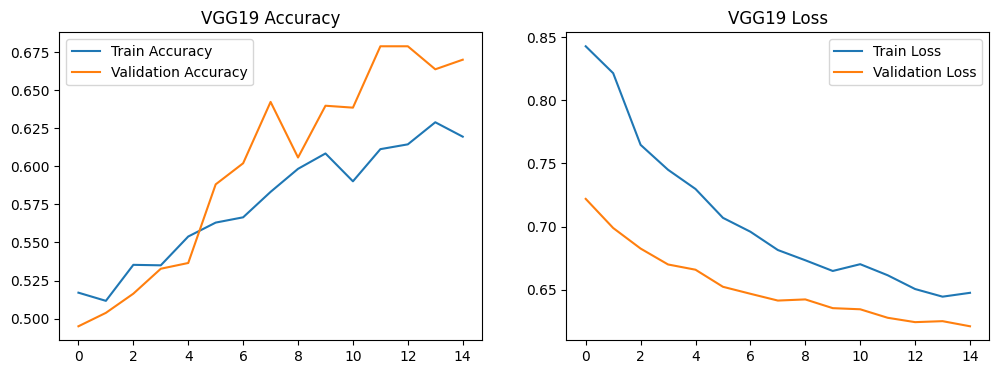

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6704 - loss: 0.6285

VGG19 Model Test Accuracy: 0.6724
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


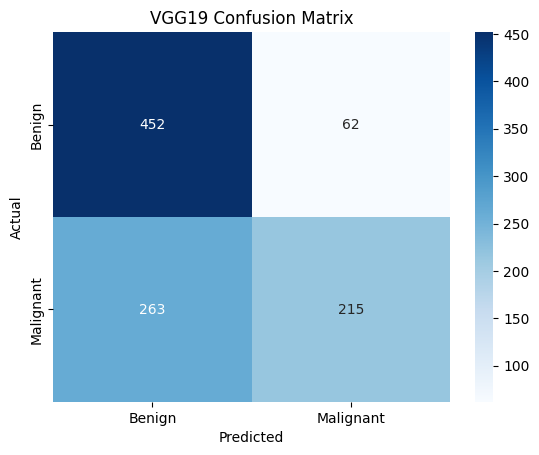


VGG19 Classification Report:
               precision    recall  f1-score   support

      Benign       0.63      0.88      0.74       514
   Malignant       0.78      0.45      0.57       478

    accuracy                           0.67       992
   macro avg       0.70      0.66      0.65       992
weighted avg       0.70      0.67      0.66       992



In [15]:
print("\nVGG19 Model Results:")
vgg19_model = VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
train_and_evaluate_model(vgg19_model, 'VGG19')

### **EFFICIENTNET MODEL**


EfficientNetB0 Model Results:
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.4891 - loss: 0.7286 - val_accuracy: 0.5050 - val_loss: 0.6935
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4915 - loss: 0.7100 - val_accuracy: 0.4950 - val_loss: 0.6938
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5143 - loss: 0.6986 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5024 - loss: 0.6998 - val_accuracy: 0.5050 - val_loss: 0.6930
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5126 - loss: 0.6970 - val_accuracy: 0.4950 - val_loss: 0.6938
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5161 - loss: 0.6958 - val_accuracy: 0.4950 - val_loss: 0.6934


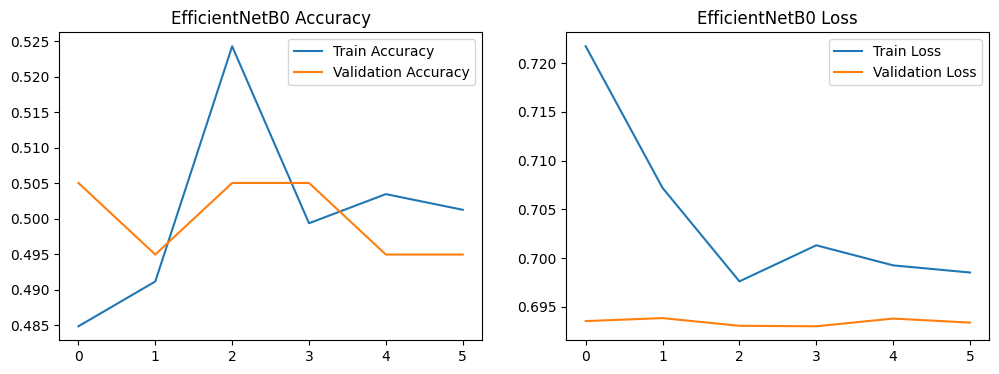

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4753 - loss: 0.6959

EfficientNetB0 Model Test Accuracy: 0.4819
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


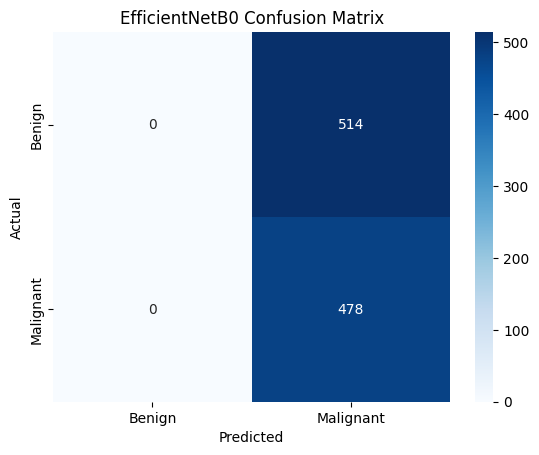


EfficientNetB0 Classification Report:
               precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       514
   Malignant       0.48      1.00      0.65       478

    accuracy                           0.48       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.23      0.48      0.31       992



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
print("\nEfficientNetB0 Model Results:")
train_and_evaluate_model(EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet'), 'EfficientNetB0')

### **DENSENET 121 MODEL**


DenseNet121 Model Results:
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 342ms/step - accuracy: 0.5190 - loss: 0.9986 - val_accuracy: 0.6171 - val_loss: 0.6386
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.5481 - loss: 0.8266 - val_accuracy: 0.6965 - val_loss: 0.5997
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5963 - loss: 0.7317 - val_accuracy: 0.7305 - val_loss: 0.5770
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6294 - loss: 0.6873 - val_accuracy: 0.7519 - val_loss: 0.5614
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6366 - loss: 0.6608 - val_accuracy: 0.7645 - val_loss: 0.5530
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6437 - loss: 0.6580 - val_accuracy: 0.7821 - val_loss: 0.5466
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6797 - loss: 0.6173 - val_accuracy: 0.7960 - val_loss: 0.5375
Epoch 8/15
100

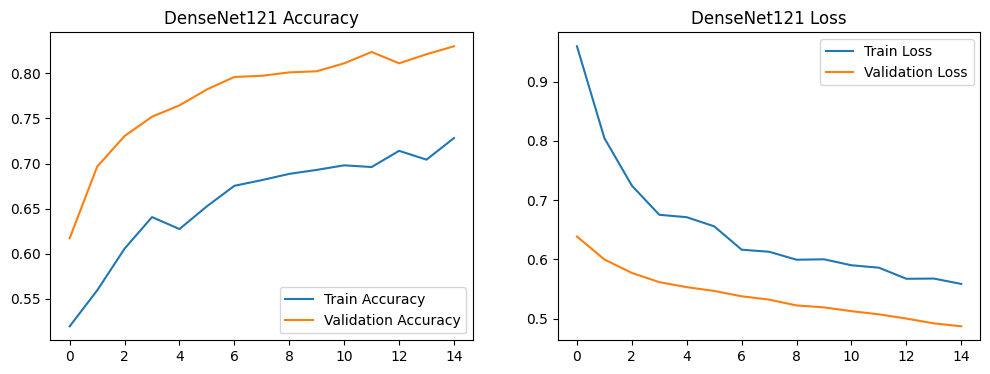

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8093 - loss: 0.4939

DenseNet121 Model Test Accuracy: 0.8054
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step


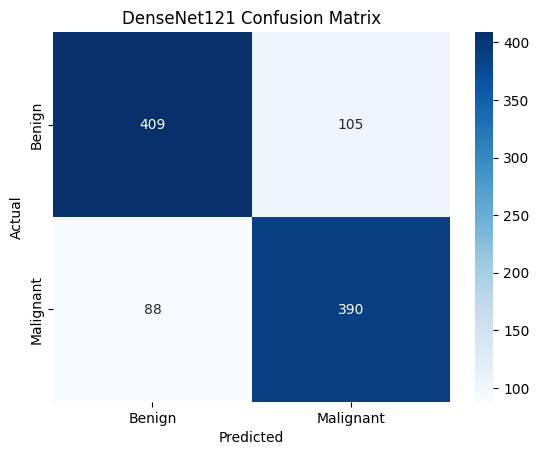


DenseNet121 Classification Report:
               precision    recall  f1-score   support

      Benign       0.82      0.80      0.81       514
   Malignant       0.79      0.82      0.80       478

    accuracy                           0.81       992
   macro avg       0.81      0.81      0.81       992
weighted avg       0.81      0.81      0.81       992



In [17]:
print("\nDenseNet121 Model Results:")
densenet_model = DenseNet121(input_shape=(128, 128, 3), include_top = False, weights= 'imagenet')
train_and_evaluate_model(densenet_model, 'DenseNet121')

### **INCEPTIONV3 MODEL**


InceptionV3 Model Results:
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step - accuracy: 0.5186 - loss: 1.4581 - val_accuracy: 0.6474 - val_loss: 0.6298
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6089 - loss: 0.8751 - val_accuracy: 0.7003 - val_loss: 0.5965
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6233 - loss: 0.7368 - val_accuracy: 0.6927 - val_loss: 0.6060
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6285 - loss: 0.6635 - val_accuracy: 0.6990 - val_loss: 0.6029
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6509 - loss: 0.6392 - val_accuracy: 0.7116 - val_loss: 0.5903
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6626 - loss: 0.6203 - val_accuracy: 0.7116 - val_loss: 0.5888
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.6441 - loss: 0.6389 - val_accuracy: 0.7242 - val_loss: 0.5818
Epoch 8/15
100/

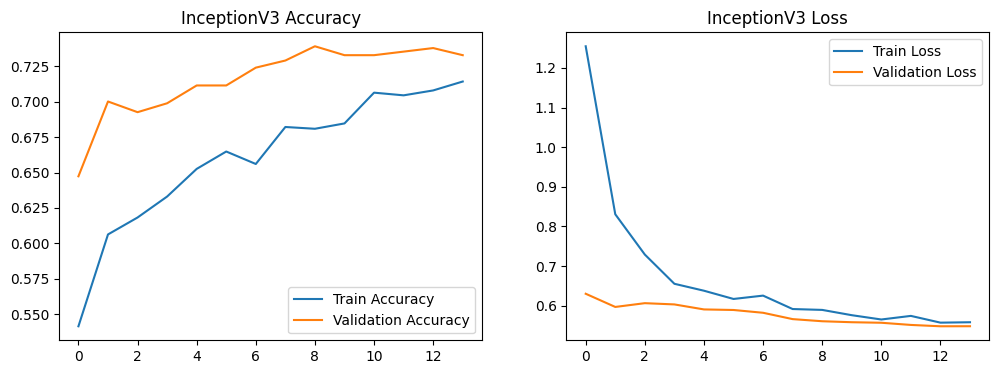

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7510 - loss: 0.5614

InceptionV3 Model Test Accuracy: 0.7440
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


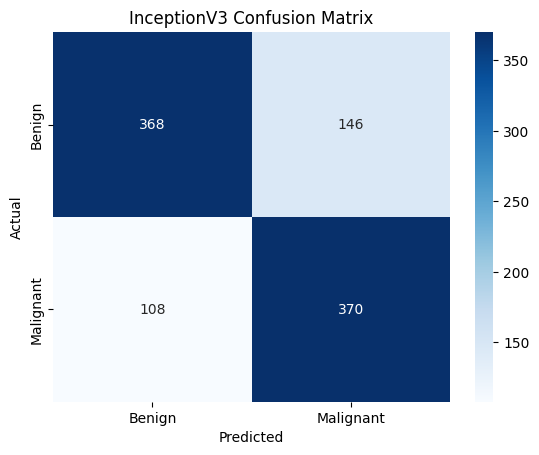


InceptionV3 Classification Report:
               precision    recall  f1-score   support

      Benign       0.77      0.72      0.74       514
   Malignant       0.72      0.77      0.74       478

    accuracy                           0.74       992
   macro avg       0.75      0.75      0.74       992
weighted avg       0.75      0.74      0.74       992



In [18]:
from tensorflow.keras.applications import InceptionV3
print("\nInceptionV3 Model Results:")
train_and_evaluate_model(InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet'), 'InceptionV3')

### **TESTING WITH DENSENET MODEL**

In [28]:
def test_sample_images(model, test_images, test_labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(test_images) - 1)
        image = test_images[idx]
        true_label = "Malignant" if test_labels[idx] == 1 else "Benign"

        # Make prediction
        prediction = model.predict(np.expand_dims(image, axis=0))
        pred_label = "Malignant" if np.argmax(prediction) == 1 else "Benign"
        prob_score = np.max(prediction)

        # Display image and prediction result
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({prob_score:.2f})")
        plt.axis('off')

    plt.suptitle("Sample Predictions with Probability Scores", fontsize=16)
    plt.show()


Testing DenseNet121 Model on Sample Images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


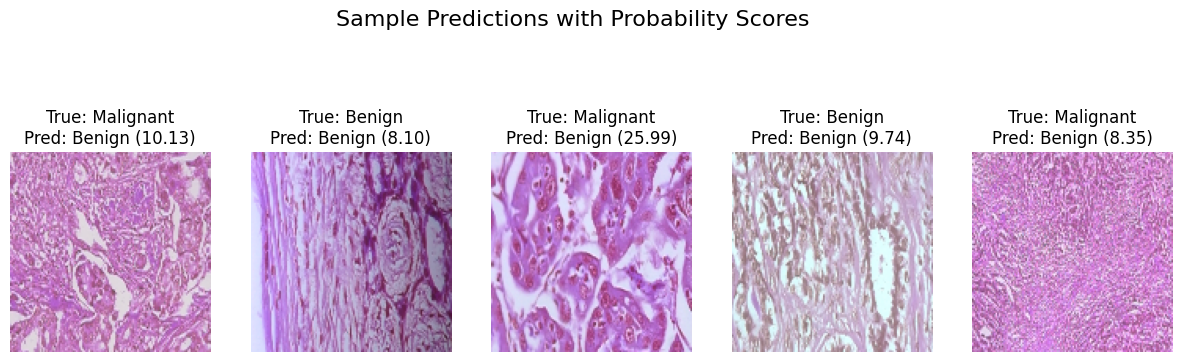

In [29]:
print("\nTesting DenseNet121 Model on Sample Images:")
test_sample_images(densenet_model, x_test, np.argmax(y_test, axis=1))